# 0909

과대적합 방지: 학습 파라미터 줄이기 
모델 성능 높이기 : 레이어 측면 - 추가-개선을 위해서 네트워크를 개선해야 함
데이터 측면: 더 좋은 데이터를 더 많이 사용

SpatialDropout2D: 2D 공간에서 특정 뉴런을 무작위로 드롭아웃합니다.
ReduceLROnPlateau: 학습 성능이 개선되지 않을 경우 학습률을 동적으로 감소시킵니다.
ImageDataGenerator: 이미지 데이터를 실시간으로 증강(augmentation)시키는 클래스입니다. 데이터 양을 늘리고 과적합을 방지하기 위해 이미지 회전, 확대, 축소 등의 변환을 수행할 수 있습니다.

In [1]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-white")

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    Dropout,
    Input,
    Conv2D,
    MaxPooling2D,
    SpatialDropout2D,
    Flatten,
    Reshape,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Add a channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# Normalize the images to a pixel value between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [3]:
class_names = [
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
]

In [4]:
def build_model():
    input = Input(shape=(28, 28, 1))
    output = Conv2D(32, (3, 3), activation="relu")(input) # 커널수:32, 3x3 필터, 활성화 함수 relu
    output = Conv2D(64, (3, 3), activation="relu")(output)
    output = Conv2D(64, (3, 3), activation="relu")(output)
    output = Flatten()(output)
    output = Dense(128, activation="relu")(output) #출력 뉴런수:128, 활성화 함수 relu
    output = Dense(64, activation="relu")(output)
    output = Dense(10, activation="softmax")(output) # 10개의 클래스, 활성화 함수 softmax, 가장 높은 확률로 분류

    model = Model(inputs=[input], outputs=output)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],  # parse_categorical_crossentropy: 클래스가 정수일때 사용
    )

    return model


model_1 = build_model()
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,029,706 (15.37 MB)

 Trainable params: 4,029,706 (15.37 MB)

 Non-trainable params: 0 (0.00 B)

라마3도 파이토치로 구성되어있어 텐서플로우와 파이토치를 제대로 쓸 줄 알아야함

In [9]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
)

hist_1 = model_1.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping],
)

Epoch 1/40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - acc: 0.9895 - loss: 0.0309
Epoch 1: val_loss improved from inf to 0.39549, saving model to best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - acc: 0.9895 - loss: 0.0310 - val_acc: 0.9103 - val_loss: 0.3955
Epoch 2/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - acc: 0.9908 - loss: 0.0257
Epoch 2: val_loss did not improve from 0.39549
329/329 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - acc: 0.9908 - loss: 0.0257 - val_acc: 0.9094 - val_loss: 0.4531
Epoch 3/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.9945 - loss: 0.0164
Epoch 3: val_loss did not improve from 0.39549
329/329 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - acc: 0.9945 - loss: 0.0164 - val_acc: 0.9026 - val_loss: 0.4784
Epoch 4/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9934 - loss: 0.0190
Epoch 4: val_loss did not improve from 0.39549
329/329 ━━━━━━━━━━━━━━━━━━━━ 36s 108ms/step - acc: 0.9934 - loss: 0.0190 - val_acc: 0.9134 - val_loss: 0.4776
Epoch 5

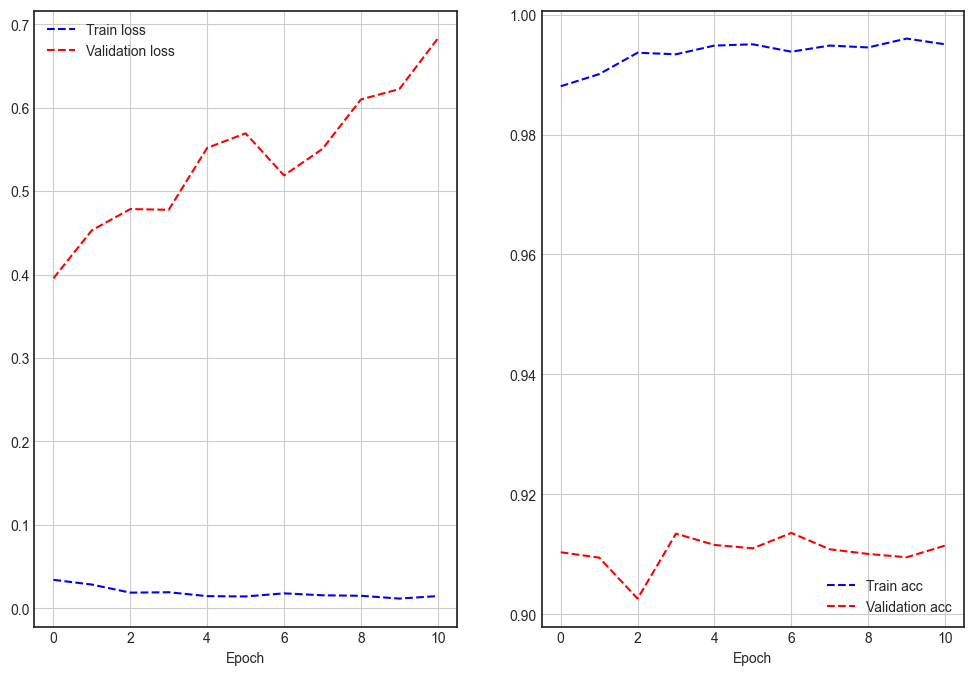

In [10]:
hist_1.history.keys()
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(hist_1.history['loss'],'b--', label='Train loss')
plt.plot(hist_1.history['val_loss'],'r--', label='Validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_1.history['acc'],'b--', label='Train acc')
plt.plot(hist_1.history['val_acc'],'r--', label='Validation acc')
plt.xlabel('Epoch')
plt.grid()
plt.legend()


In [ ]:
model_1.evaluate(x_test, y_test)

현재 모델은 0.85정도의 정확도를 보이고 있음

에포크는 2이상 할 이유가 없음

모델을 개선하기 위해 파라미터를 줄이고 레이어를 추가하고 데이터를 더 좋게 사용해야함

## 모델 개선 
맥스풀링, 드롭아웃 적용

### 모델 구성 및 학습: 과대적합 방지

- 학습 파라미터의 수 비교
  - 모델 1은 더 많은 Conv2D 레이어를 포함하고 있으며, MaxPooling2D 및 Dropout 레이어가 없으므로 학습할 파라미터가 더 많습니다.
  - 모델 2는 Conv2D 레이어 후 MaxPooling2D와 Dropout 레이어를 추가하여 파라미터 수를 줄이는 동시에, 과적합을 방지하는 데 더 신경 쓴 모델입니다.

In [11]:
def build_model2():
    input = Input(shape=(28, 28, 1))
    output = Conv2D(32, (3, 3), activation="relu")(
        input
    )  # 커널수:32, 3x3 필터, 활성화 함수 relu
    output = MaxPooling2D(strides=(2, 2))(output)
    output = Conv2D(64, (3, 3), activation="relu")(output)
    output = Dropout(0.4)(output)
    output = MaxPooling2D(strides=(2, 2))(output)
    output = Conv2D(64, (3, 3), activation="relu")(output)
    output = Dropout(0.4)(output)
    output = MaxPooling2D(strides=(2, 2))(output)
    output = Flatten()(output)
    output = Dense(128, activation="relu")(output)  # 출력 뉴런수:128, 활성화 함수 relu
    output = Dense(64, activation="relu")(output)
    output = Dense(10, activation="softmax")(
        output
    )  # 10개의 클래스, 활성화 함수 softmax, 가장 높은 확률로 분류

    model = Model(inputs=[input], outputs=output)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],  # parse_categorical_crossentropy: 클래스가 정수일때 사용
    )

    return model

model_2 = build_model2()
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,970 (285.04 KB)

 Trainable params: 72,970 (285.04 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    "best_model2.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
)

hist_2 = model_2.fit(
    x_train,
    y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping],
)

Epoch 1/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.8348 - loss: 0.4576
Epoch 1: val_loss improved from inf to 0.51426, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8348 - loss: 0.4575 - val_acc: 0.8467 - val_loss: 0.5143
Epoch 2/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8443 - loss: 0.4262
Epoch 2: val_loss improved from 0.51426 to 0.50899, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - acc: 0.8443 - loss: 0.4261 - val_acc: 0.8457 - val_loss: 0.5090
Epoch 3/40
326/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8490 - loss: 0.4083
Epoch 3: val_loss improved from 0.50899 to 0.47486, saving model to best_model2.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.8490 - loss: 0.4082 - val_acc: 0.8468 - val_loss: 0.4749
Epoch 4/40
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8593 - loss: 0.3879
Epoch 4: val_loss improved from 0.47486 to 0.47073, saving model to best_model2.keras
329/329 

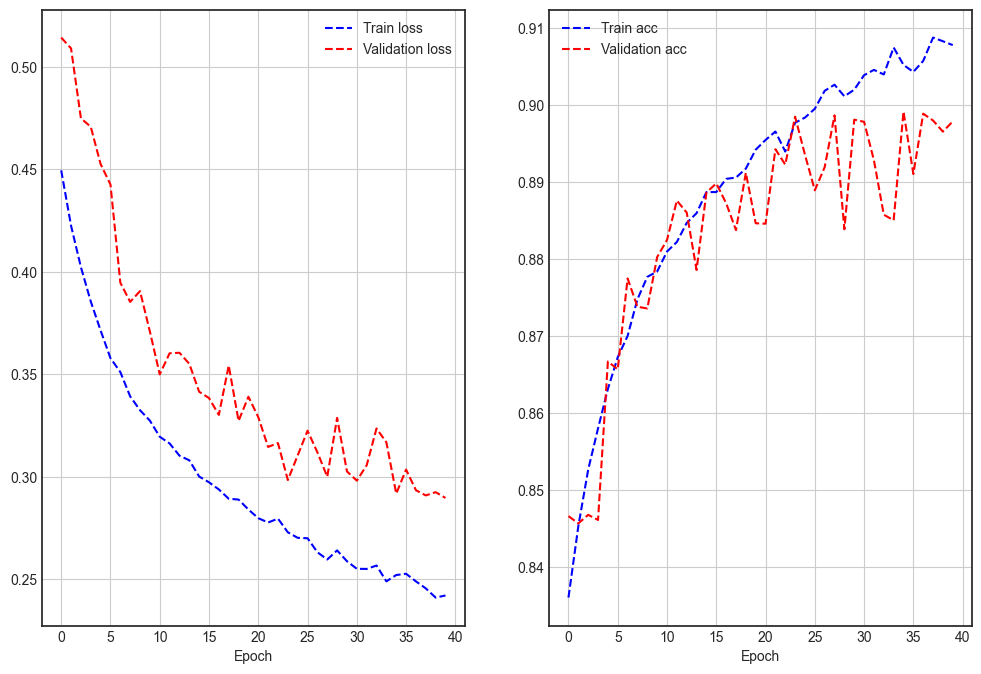

In [15]:
hist_2.history.keys()
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(hist_2.history["loss"], "b--", label="Train loss")
plt.plot(hist_2.history["val_loss"], "r--", label="Validation loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_2.history["acc"], "b--", label="Train acc")
plt.plot(hist_2.history["val_acc"], "r--", label="Validation acc")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

과대적합이 개선됨을 확인할 수 있습니다.

에포크는 40 이상해도 괜찮을 것 같음



In [16]:
model_2.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8890 - loss: 0.3134


[0.30860215425491333, 0.890500009059906]

### 모델 성능 높이기: 레이어 추가

padding='same'과 'valid'옵션을 코드 내에서 별도로 설정하는 이유
- 모델 설계자가 네트워크의 각 계층에서 출력의 크기와 특성 추출 방식을 세밀하게 제어하고자 하는 것이다.
- 아래 경우에는 초기에는 공간 차원을 유지하면서 입력 데이터의 전반적인 특성을 포착하고 네트워크가 깊어질 수록 더 추상화된 특성을 추출하려는 목적으로 생각해 볼 수 있음.
- same 옵션은 입력과 출력의 크기가 동일하도록 출력의 크기를 조정하고, valid 옵션은 출력의 크기를 입력의 크기보다 작게 만들어 특성을 추출하는 방식으로 생각할 수 있음.

In [17]:
def build_model3():
    input = Input(shape=(28, 28, 1))
    output = Conv2D(32, (3, 3), activation="relu", padding='same')(
        input
    )  # 커널수:32, 3x3 필터, 활성화 함수 relu
    output = BatchNormalization()(output)
    output = Conv2D(64, (3, 3), activation="relu", padding='valid')(output)
    output = Dropout(0.5)(output)
    output = MaxPooling2D(strides=(2, 2))(output)
    
    output = Conv2D(64, (3, 3), activation="relu", padding='same')(output)
    output = BatchNormalization()(output)
    output = Conv2D(128, (3, 3), activation="relu", padding='valid')(output)
    output = Dropout(0.5)(output)
    output = MaxPooling2D(strides=(2, 2))(output)
    
    output = Conv2D(256, (3, 3), activation="relu", padding='same')(output)
    output = BatchNormalization()(output)
    output = Conv2D(256, (3, 3), activation="relu", padding='valid')(output)
    output = Dropout(0.5)(output)
    output = MaxPooling2D(strides=(2, 2))(output)
    
    output = Flatten()(output)
    output = Dense(512, activation="relu")(output)  # 출력 뉴런수:128, 활성화 함수 relu
    output = Dropout(0.5)(output)
    output = Dense(256, activation="relu")(output)
    output = Dropout(0.5)(output)
    output = Dense(10, activation="softmax")(
        output
    )  # 10개의 클래스, 활성화 함수 softmax, 가장 높은 확률로 분류

    model = Model(inputs=[input], outputs=output)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],  # parse_categorical_crossentropy: 클래스가 정수일때 사용
    )

    return model


model_3 = build_model3()
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,738 (4.89 MB)

 Trainable params: 1,281,034 (4.89 MB)

 Non-trainable params: 704 (2.75 KB)

In [18]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    "best_model3.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
)

hist_3 = model_3.fit(
    x_train,
    y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping],
)

Epoch 1/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - acc: 0.5929 - loss: 1.2083
Epoch 1: val_loss improved from inf to 2.17593, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 71s 206ms/step - acc: 0.5937 - loss: 1.2058 - val_acc: 0.2711 - val_loss: 2.1759
Epoch 2/40
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - acc: 0.8322 - loss: 0.4712
Epoch 2: val_loss improved from 2.17593 to 1.03284, saving model to best_model3.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 104s 316ms/step - acc: 0.8323 - loss: 0.4710 - val_acc: 0.7996 - val_loss: 1.0328
Epoch 3/40
 36/329 ━━━━━━━━━━━━━━━━━━━━ 1:36 329ms/step - acc: 0.8620 - loss: 0.4085

KeyboardInterrupt: 

In [ ]:
hist_3.history.keys()
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(hist_3.history["loss"], "b--", label="Train loss")
plt.plot(hist_3.history["val_loss"], "r--", label="Validation loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_3.history["acc"], "b--", label="Train acc")
plt.plot(hist_3.history["val_acc"], "r--", label="Validation acc")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

### CNN(Convolutional Neural Network)에서 파라미터 수의 증가 요소

- 필터(커널)의 수: CNN의 각 합성곱 계층(Convolutional layer)은 여러 필터(또는 커널)를 사용하여 입력 이미지에서 특징을 추출합니다. 필터의 수가 많아질수록 더 많은 특징을 동시에 학습할 수 있지만, 이는 동시에 해당 계층의 파라미터 수를 증가시킵니다.

- 필터의 크기: 필터의 크기가 클수록 한 번에 더 넓은 영역의 정보를 처리할 수 있습니다. 그러나 필터 크기의 증가는 필터 내의 가중치 수를 증가시켜, 결과적으로 해당 계층의 전체 파라미터 수를 증가시킵니다.

- 완전연결계층(Fully Connected layers)의 크기: CNN의 끝부분에서 주로 사용되는 전결합 계층은 모든 입력을 각 출력 뉴런에 연결합니다. 이 계층의 뉴런(유닛) 수가 많을수록 모델의 파라미터 수가 크게 증가합니다. 전결합 계층은 일반적으로 모델 내에서 가장 많은 파라미터를 가집니다.

- 계층의 깊이: CNN의 계층(레이어) 수가 많아질수록, 즉 모델이 더 깊어질수록, 모델이 더 복잡한 특징을 학습할 수 있게 되지만, 이는 또한 전체 파라미터 수를 증가시킵니다.

- 특성 맵(Feature Map)의 크기: 특정 합성곱 계층이 출력하는 특성 맵의 크기가 크면 클수록, 그 다음 계층(특히 전결합 계층이나 합성곱 계층)의 파라미터 수가 증가할 수 있습니다. 특성 맵의 크기는 입력 이미지의 크기와 필터의 크기, 스트라이드(stride), 패딩(padding)에 의해 결정됩니다.

이러한 요소들은 모두 모델의 학습 능력과 일반화 능력에 영향을 미칩니다. 파라미터 수가 많은 모델은 더 복잡한 특징을 학습할 수 있지만, 과적합(overfitting)의 위험도 높아질 수 있습니다. 반면, 파라미터 수가 적은 모델은 계산 효율성은 높지만, 모델의 표현 능력이 제한될 수 있습니다. 따라서 모델 설계 시 이러한 점을 고려하여 적절한 균형을 찾는 것이 중요합니다.

학습을 통해 가중치 업데이트



### 모델 성능 높이기: 이미지 증강(Image Augmentation)
데이터 증강은 기존의 훈련 데이터를 다양하게 변형하여 모델의 일반화 능력을 향상시키는 기법입니다. 각 파라미터는 특정 방식으로 이미지를 변형합니다.

ImageDataGenerator 파라미터 설명:
- rotation_range=10: 이미지를 -10도에서 10도 사이로 무작위로 회전합니다.
- zoom_range=0.2: 이미지를 80%에서 120% 사이로 무작위로 확대/축소합니다.
- shear_range=0.6: 이미지를 반시계 방향으로 0.6 라디안 내에서 기울입니다.
- width_shift_range=0.1와 height_shift_range=0.1: 각각 이미지를 수평과 수직으로 최대 10% 내에서 무작위로 이동합니다.
- horizontal_flip=True: 수평 방향으로 이미지를 무작위로 뒤집습니다. (예: 좌우 반전)
- vertical_flip=False: 수직 방향으로 이미지를 뒤집지 않습니다.

일반적으로 데이터는 언제나 부족

데이터 늘리는 것도 노하우 영역

학습 데이터를 늘리는 것은 부가가치가 있는 일



In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

augment_size = 200
print(x_train.shape)
print(x_train[0].shape)

(60000, 28, 28, 1)
(28, 28, 1)


(200, 28, 28, 1)


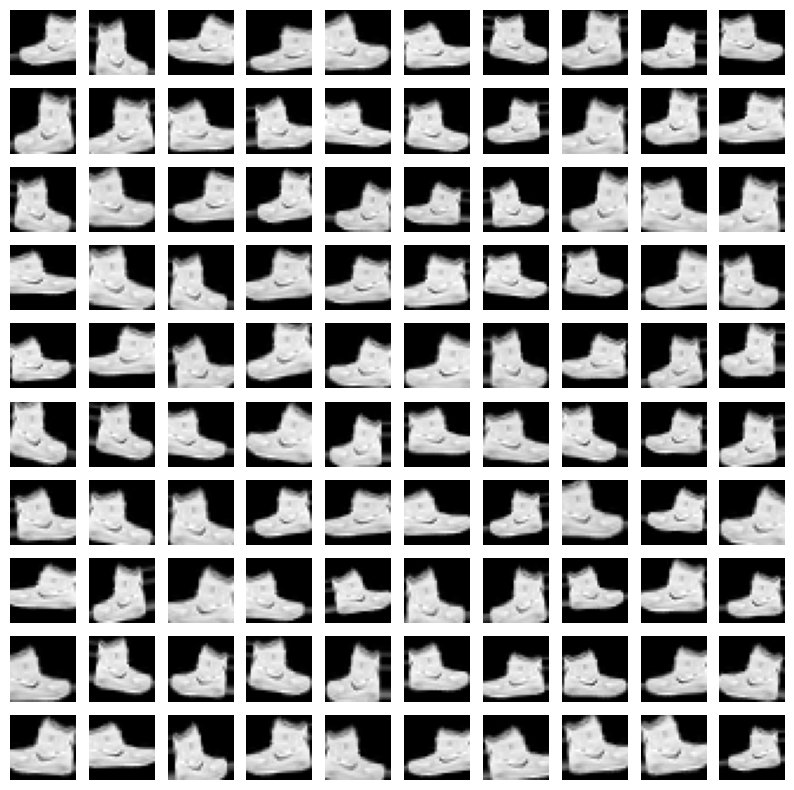

In [20]:
#flow() 함수는 이미지 데이터를 증식시키는 함수
# np.tile() 함수는 이미지 데이터를 복사하는 함수
# np.tile(x_train[0].reshape(28*28*1), augment_size).reshape(-1, 28, 28, 1)은 x_train[0]을 augment_size만큼 복사하여 증강된 이미지 데이터 형태로 만든다.
# np.zeros(augment_size)는 0으로 채워진 배열을 만든다. 증강된 이미지 데이터의 레이블을 0으로 설정한다.
# batch_size=augment_size는 한번에 생성할 증강된 이미지의 수를 지정
# next()[0]은 생성된 이미지 배치 중 첫번째 배치(증강된 이미지 데이터)에 접근
# 이미지 증강

x_augment_iterator = image_generator.flow(
    np.repeat(x_train[0].reshape(1, 28, 28, 1), augment_size, axis=0),  #이미지 데이터를 복사하여 증식
    np.zeros(augment_size), #라벨은 필요하지 않으므로 0으로 설정
    batch_size=augment_size,
    shuffle=False,
)

# next() 함수를 사용하여 생성된 이미지 데이터를 가져온다.
# [0]: flow() 로 반환된 데이터는 (이미지 데이터, 라벨 데이터) 형식으로 반환되기 때문에 [0]을 사용하여 이미지 데이터만 가져온다.
x_augment = next(x_augment_iterator)[0]

print(x_augment.shape)

plt.figure(figsize=(10, 10))
for i in range(1,101):
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.imshow(x_augment[i-1].reshape(28, 28), cmap='gray')
    

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Add a channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# Normalize the images to a pixel value between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [26]:
image_generator = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.6,
    width_shift_range=0.15,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

augment_size = 30000
random_mask = np.random.randint(x_train.shape[0], size=augment_size)  # x_train.shape[0]개 중에서 augment_size만큼 랜덤하게 선택
x_augmented = x_train[random_mask].copy()
y_augmented = y_train[random_mask].copy()

# 증강할 이미지 데이터 생성
x_augmented = image_generator.flow(x_augmented,  # 증식하는게 아니라 배치별로 이미지가 랜덤하게 변형
                                   np.zeros(augment_size), 
                                   batch_size=augment_size, 
                                   shuffle=False
                                   )
x_augmented = next(x_augmented)[0]
print(x_augmented.shape)


(30000, 28, 28, 1)


3만개 만들고 기존 6만개에 추가할 예정

In [27]:
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented))

print(x_train.shape)
print(y_train.shape)

(90000, 28, 28, 1)
(90000,)


In [28]:
model_4 = build_model3()
model_4.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,738 (4.89 MB)

 Trainable params: 1,281,034 (4.89 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    "best_model4.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
)

hist_4 = model_4.fit(
    x_train,
    y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping],
)

In [ ]:
hist_4.history.keys()
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(hist_4.history["loss"], "b--", label="Train loss")
plt.plot(hist_4.history["val_loss"], "r--", label="Validation loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_4.history["acc"], "b--", label="Train acc")
plt.plot(hist_4.history["val_acc"], "r--", label="Validation acc")
plt.xlabel("Epoch")
plt.grid()
plt.legend()

In [ ]:
model_4.evaluate(x_test, y_test)

데이터 증식이 노하우

챗지피티로 데이터 증식도 많이 한다고 함

모델을 만들기 위한 데이터 증식

교육분야에도 적용될게 많음

양질의 데이터를 만들수 있는 노하우

특정 도메인 분야라도 양질의 데이터를 만들어야 함